<a href="https://colab.research.google.com/github/nahumsa/Entanglement-VAE/blob/master/VAE%20Entanglement%20Witness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating entangled and separable states with qutip

## Installing dependencies

In [0]:
!git clone https://github.com/nahumsa/Entanglement-VAE.git

In [0]:
!pip install qutip

In [0]:
% cd Entanglement-VAE/

## Creating the dataset

We want to take the partial transpose of the density matrix and check if it $\rho > 0$. [link](https://en.wikipedia.org/wiki/Peres%E2%80%93Horodecki_criterion)

Here we are following the Perez-Horondecki criterion, if the partial transpose of the density matrix is negative, the state has to be entangled. 

Because it the state is separable, it will be positive definite by definition.

In [5]:
try:
  %tensorflow_version 1.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.compat.v1.set_random_seed(1234)

import warnings
warnings.filterwarnings("ignore")

TensorFlow 1.x selected.


In [0]:
from itertools import product
import qutip as qutip
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def measurement(density_matrix, base, name_base):
  """Measuring the quantum state on a given basis.
  """
  _measurements_names = []
  _measurements = []

  for (name_1, meas_1),(name_2,meas_2) in product(zip(name_base, base),zip(name_base, base)):
    #Ignore the II measurement because it is always 1
    if name_1 == 'I' and name_2 == 'I':
      pass
    else:
      measurement_op = qutip.tensor(meas_1,meas_2)
      _measurements.append(qutip.expect(measurement_op, density_matrix))
      _measurements_names.append(name_1 + name_2)

  return [i for i in zip(_measurements, _measurements_names)]

def create_density_matrix(base,name_base):
  """ Create a random density matrix."""

  for (name_1, basis_1),(name_2, basis_2) in product(zip(name_base, base),zip(name_base, base)):
    if name_1 == 'I' and name_2 == 'I':
      density_matrix = 0.25*qutip.tensor(basis_1, basis_2)
    else: 
      density_matrix += 0.25*np.random.rand()*qutip.tensor(basis_1,basis_2)
  
  return density_matrix

def create_dataset(n_samples):
  
  _states = []
  _labels = []
  _measurements = []

  #Basis Measured
  name_basis = ['I', 'X', 'Y', 'Z']
  basis = [qutip.identity(2), qutip.sigmax(),qutip.sigmay(),qutip.sigmaz()]



  for _ in range(n_samples):    
    density = qutip.rand_dm(4, density=0.75, dims=[[2,2],[2,2]])
    
    #Partial Transpose
    density_partial_T = qutip.partial_transpose(density, [0,1])    
  
    #Labels: 1 if entangled 0 if separable (PPT Criterion)
    if (density_partial_T.eigenenergies() < 0).any():
      _labels.append(1)
  
    else:      
      _labels.append(0)  

    _states.append(density)  
  
    val_measurements = measurement(density_matrix=density, 
                                   base=basis, 
                                   name_base=name_basis)
  
    _measurements.append(val_measurements)
    
  return _states, _measurements, _labels

In [0]:
samples_train = 5000
states_train, measurements_train, labels_train = create_dataset(samples_train)

samples_test = 3000
states_test, measurements_test, labels_test = create_dataset(samples_test)

Checking the distribution of the labels.

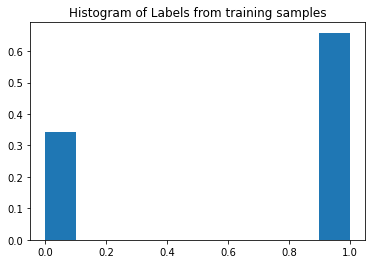

In [20]:
weights = np.ones_like(labels_train)/float(len(labels_train))
plt.hist(labels_train, weights=weights)
plt.title('Histogram of Labels from training samples')
plt.show()

There are more entangled states than separable states as expected.

In [0]:
#Unpacking the training data
def create_x(measurement):
  """Create an list with measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:      
      aux.append(result)
    X.append(aux)
  return X

#Transforming in an np.array
X_train = np.array(create_x(measurements_train))
Y_train = np.array(labels_train)
#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)

X_test = np.array(create_x(measurements_test))
Y_test = np.array(labels_test)
#transform into categories
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

In [22]:
print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 15) 
 Y:(5000, 2)






#Variational Autoencoder for all measurements

In [0]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from keras.models import Model
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256]
decoder_dense = [256, 512, 2]
batch_norm = True
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.005
R_LOSS_FACTOR = 5000
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

#Callbacks 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_LR = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, min_lr=0)

early_stopping = EarlyStopping(monitor='val_acc', 
                               min_delta=0.01, 
                               patience=5, 
                               verbose=1, 
                               mode='max', 
                               restore_best_weights=True)

callbacks = [reduce_LR]

# Training Parameters
BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train( x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    , callbacks = callbacks
                    )

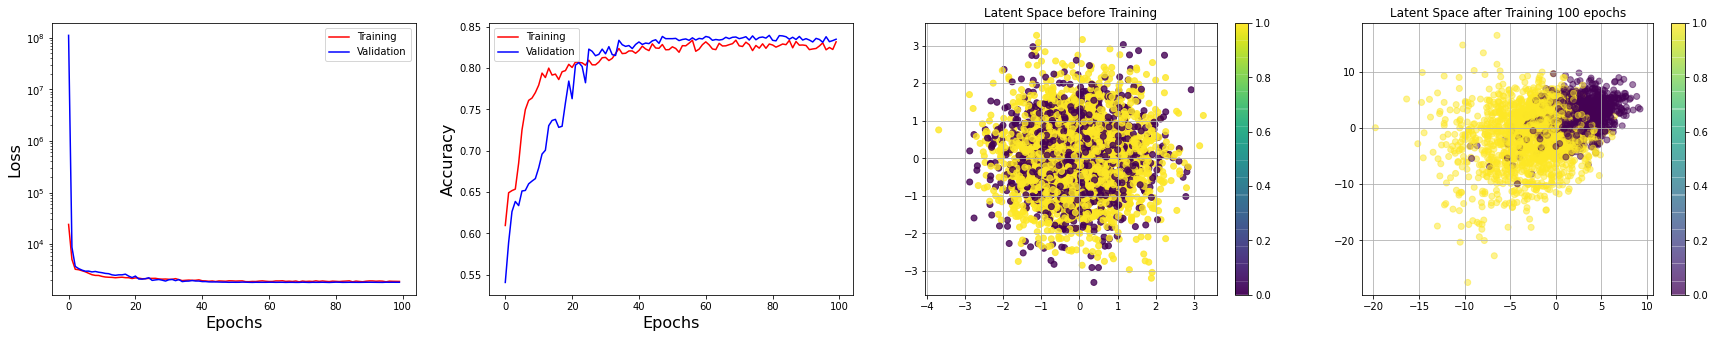

In [55]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,5))


ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_yscale('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], alpha=0.8, c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu[:, 0], z_mu[:, 1], alpha=0.5, c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()





#Variational Autoencoder with limited measurements

In [0]:
#Unpacking the training data
def create_x_without_I(measurement):
  """Create an list with measurements"""
  X = []
  for meas in measurement:
    aux = []
    for result , name in meas:
      if name[0] == 'I' or name[1] == 'I':  
        pass
      else:
        aux.append(result)
    X.append(aux)
  return X

#Transforming in an np.array
X_train = np.array(create_x_without_I(measurements_train))
Y_train = np.array(labels_train)
#transform into categories
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes= 2)

X_test = np.array(create_x_without_I(measurements_test))
Y_test = np.array(labels_test)
#transform into categories
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

print(f"Shape of the Training: \n X: {X_train.shape} \n Y:{Y_train_cat.shape}")

Shape of the Training: 
 X: (5000, 9) 
 Y:(5000, 2)


In [0]:
import os
# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'Entanglement_limited'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
from keras.models import Model
from Models.ENT_VAE import EntanglementSoftmax

#Parameters
input_dimension = (X_train.shape[1],)
encoder_dense = [512,256]
decoder_dense = [256, 512, 2]
batch_norm = True
dropout = True
ZDIM = 2

#Defining the Beta-VAE
bvae = EntanglementSoftmax(input_dim = input_dimension
                                        , encoder_dense_units = encoder_dense
                                        , decoder_dense_units = decoder_dense
                                        , z_dim = ZDIM
                                        , use_batch_norm = batch_norm
                                        , use_dropout= dropout
                                        )

z_mu_b = bvae.encoder.predict(X_test)

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 1
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

# Training Parameters

BATCH_SIZE = 256
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

history = bvae.train(     
                      x_train = X_train
                    , y_train = Y_train_cat
                    , batch_size = BATCH_SIZE
                    , validation_data = (X_test, Y_test_cat)
                    , epochs = EPOCHS
                    , run_folder = RUN_FOLDER
                    , print_every_n_batches = PRINT_EVERY_N_BATCHES
                    , initial_epoch = INITIAL_EPOCH                    
                    )

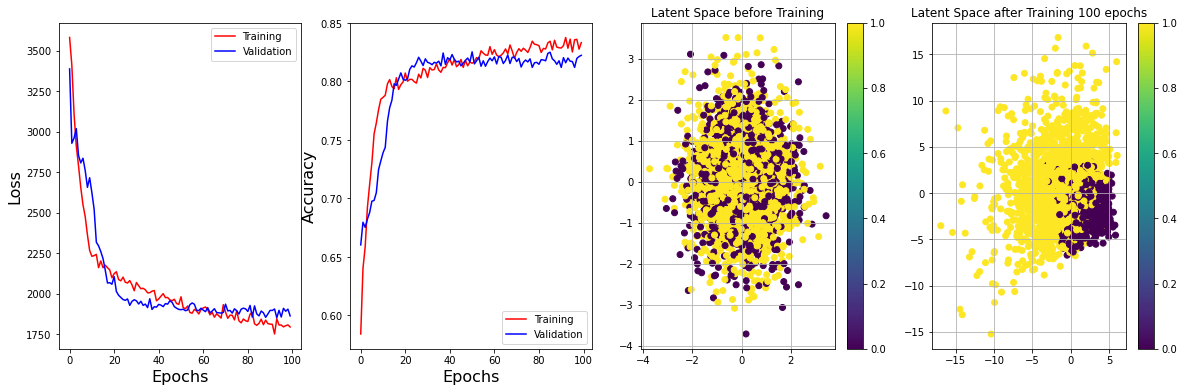

In [0]:
#Metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

#Epochs
epochs = np.arange(INITIAL_EPOCH, EPOCHS, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()

ims = ax3.scatter(z_mu_b[:, 0], z_mu_b[:, 1], c=Y_test)
ax3.set_title(f'Latent Space before Training')
ax3.grid()
plt.colorbar(ims, ax=ax3)

z_mu = bvae.encoder.predict(X_test)
ims = ax4.scatter(z_mu[:, 0], z_mu[:, 1], c=Y_test)
ax4.set_title(f'Latent Space after Training {EPOCHS} epochs')
ax4.grid()
plt.colorbar(ims, ax=ax4)
plt.show()